In [1]:
# To run this in Google Colab, uncomment the following line
# !pip install "git+https://github.com/GPflow/GeometricKernels.git"

# If you want to use a version of the library from a different git branch,
# say, from the "devel" branch, uncomment the line below instedad
# !pip install "git+https://github.com/GPflow/GeometricKernels@devel#egg=GeometricKernels"

# Matérn and Heat Kernels on the Manifold of Symmetric Positive Definite Matrices (SPD)

This notebook shows how define and evaluate kernels on the manifold of symmetric positive definite matrices $\mathbb{SPD}(2)$ of size $2 \times 2$.

Handling higher-dimensional manifolds of symmetric positive definite matrices $\mathbb{SPD}(d)$ for $d > 2$ is essentially the same.

**Note:** the points on the hyperbolic space $\mathbb{SPD}(d)$ are represented by matrices (`array`s of the suitable backend) or size $d \times d$.

We use the **numpy** backend here.

In [2]:
# Import a backend, we use numpy in this example.
import numpy as np
# Import the geometric_kernels backend.
import geometric_kernels
# Import a space and an appropriate kernel.
from geometric_kernels.spaces import SymmetricPositiveDefiniteMatrices
from geometric_kernels.kernels.geometric_kernels import MaternFeatureMapKernel
from geometric_kernels.kernels.feature_maps import random_phase_feature_map_noncompact, rejection_sampling_feature_map_hyperbolic

import matplotlib as mpl
import matplotlib.pyplot as plt

import geomstats.visualization as visualization

## Defining a Space

First we create a GeometricKernels `space` that corresponds to the 2-dimensional manifold of symmetric positive definite matrices $\mathbb{SPD}(2)$.

In [3]:
spd = SymmetricPositiveDefiniteMatrices(2)

For *non-compact symmetric spaces* such as the `SymmetricPositiveDefiniteMatrices`, the class `MaternFeatureMapKernel` should be used.

## Theory (Optional Reading)
### General Theory Behind `MaternFeatureMapKernel` for Non-compact Symmetric Spaces

TODO

We employ the kernel defined by the _random phase features_. A complete mathematical treatise can be found in [1]. For the purposes of this notebook, it suffices to say that on noncompact symmetric spaces (of which the Hyperbolic space is a fine specimen), the kernel is defined in terms of an intractable integral over a probability density (called the *spectral density*). To approximate the integral, we use Monte Carlo sampling from the spectral density.

This is in contrast to _compact_ spaces (which we call `DiscreteSpectrumSpace`s), where the kernel is a sum of a _series_, that can be approximated via truncation.

In the Hyperbolic space, there are several methods for sampling from the spectral density. We will investigate them in this notebook.

For practical purposes, we just have to define a number of _random phases_ (the more we define, the better the approximation and the more computation required), specify a feature map, and pass it to the `MaternFeatureMapKernel`. The kernel requires a `key` to instantiate randomness in the _random phases_, and is a **deterministic** function.


## Defining a Kernel

To initialize `MaternFeatureMapKernel`, you provide three parameters.
First, the `space`, in our case this is the `spd` we have just created above.
The second parameter, `feature_map`, desrves a separate description.
The third parameter is a random generator `key`.

We start with defining a *feature map*. Intuitively, this is analogous to sampling random feature (cosines or complex exponentials) in a random Fourier feature expansion. The parameter `num_random_phases` determins the number of these features. We use 3000 here, it though you can often make do with less.

In [4]:
feature_map = random_phase_feature_map_noncompact(spd, num_random_phases=3_000)

We define randomness

In [5]:
key = np.random.RandomState(seed=1234)

Now we are ready to create a generic Matérn kernel.

In [6]:
kernel = MaternFeatureMapKernel(spd, feature_map, key)

To support JAX, our classes do not contain a *state*, it is external.
The next line initializes the *state* which is composed of two parts: `params`, a dictionary with kernel parameters, and `state`, a dictionary containing the eigenpairs.

`params` are initialized with some default values.

**Note:** our kernels do not contain the outputscale/variance parameter frequently used in Gaussian processes.
However, it is usually trivial to add it by multiplying the kernel by an (optimizable) constant.

In [7]:
params, state = kernel.init_params_and_state()
print('params:', params)
print('state:', state)

params: {'nu': array(inf), 'lengthscale': array(1.)}
state: {}


To define two different kernels, Matern-3/2 and Matern-∞ (aka heat, RBF, squared exponential, diffusion), we need two different versions of `params`:

In [8]:
params["lengthscale"] = np.array([0.5])
params_32  = params.copy()
params_inf = params.copy()
del params
params_32["nu"]  = np.array([3/2])
params_inf["nu"] = np.array([np.inf])

Now two kernels are *defined* and we proceed to evaluating both on a set of random inputs.

## Evaluating Kernels on Random Inputs

We start by sampling `10` random points on the sphere $\mathbb{H}_2$.
Since the hyperbolic spaces are noncompact, the sampling cannot be uniform, we use TODO.

In [9]:
# key = np.random.RandomState(1234)

# key, xs = hyperbolic_space.random(key, 10)

xs = spd.random_point(10)

print(xs)

[[[ 0.65263749 -0.01038102]
  [-0.01038102  0.6855172 ]]

 [[ 1.03054824  0.16355063]
  [ 0.16355063  1.0902606 ]]

 [[ 1.69034607  0.27645143]
  [ 0.27645143  1.96300817]]

 [[ 1.51188663 -0.93537701]
  [-0.93537701  2.21668877]]

 [[ 0.44627963  0.16696266]
  [ 0.16696266  1.49137293]]

 [[ 3.22419599  2.16167498]
  [ 2.16167498  3.51099047]]

 [[ 1.65175624 -0.65913098]
  [-0.65913098  1.44516854]]

 [[ 1.38518635  0.27114176]
  [ 0.27114176  0.46671136]]

 [[ 0.94800614  0.40765314]
  [ 0.40765314  0.73845477]]

 [[ 2.50335583 -0.44266462]
  [-0.44266462  0.49618993]]]


Now we evaluate the two kernel matrices.

In [10]:
kernel_mat_32  = kernel.K(params_32,  state, xs, xs)
kernel_mat_inf = kernel.K(params_inf, state, xs, xs)

Finally, we visualize these matrices using `imshow`.

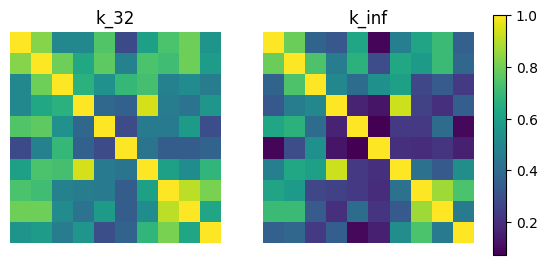

In [11]:
# find common range of values
minmin = np.min([np.min(kernel_mat_32), np.min(kernel_mat_inf)])
maxmax = np.max([np.max(kernel_mat_32), np.max(kernel_mat_inf)])

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
cmap = plt.get_cmap('viridis')

ax1.imshow(kernel_mat_32, vmin=minmin, vmax=maxmax, cmap=cmap)
ax1.set_title('k_32')
ax1.set_axis_off()

ax2.imshow(kernel_mat_inf, vmin=minmin, vmax=maxmax, cmap=cmap)
ax2.set_title('k_inf')
ax2.set_axis_off()

# add space for color bar
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.25, 0.02, 0.5])

# add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap,
                           norm=plt.Normalize(vmin=minmin, vmax=maxmax))
fig.colorbar(sm, cax=cbar_ax)

plt.show()

# Citation

If you are using hyperbolic spaces and GeometricKernels, please consider citing

```
@article{azangulov2023,
    title={Stationary Kernels and Gaussian Processes on Lie Groups and their Homogeneous Spaces II: non-compact symmetric spaces},
    author={Azangulov, Iskander and Smolensky, Andrei and Terenin, Alexander and Borovitskiy, Viacheslav},
    journal={arXiv preprint arXiv:2301.13088},
    year={2023}
}
```